In [44]:
from langgraph.graph import StateGraph, START, END
from langchain_ollama import ChatOllama
from pydantic import BaseModel, Field
from typing import TypedDict, Literal

In [45]:
model = ChatOllama(model='gemma3:4b')

In [46]:
class SentimentSchema(BaseModel):
    sentiment: Literal['positive', 'negative'] = Field(description='The sentiment of the review')

In [47]:
class DiagnosisSchema(BaseModel):
    issue_type: Literal["UX", "Performance", "Bug", "Support", "Other"] = Field(
        description='The category of issue mentioned in the review')
    tone: Literal["angry", "frustrated", "disappointed", "calm"] = Field(
        description='The emotional tone expressed by the user')
    urgency: Literal["low", "medium", "high"] = Field(description='How urgent or critical the issue appears to be')

In [48]:
structured_model1 = model.with_structured_output(SentimentSchema)
structured_model2 = model.with_structured_output(DiagnosisSchema)

In [49]:
# # test case
# prompt = "Best laptop to go with under this amount Best machine built by apple"
# response = structured_model.invoke(prompt)
# response

In [50]:
class ReviewState(TypedDict):
    review: str
    sentiment: Literal["positive", "negative"]
    diagnosis: dict
    response: str

In [51]:
def find_sentiment(state: ReviewState):
    prompt = f"For the following review find out the sentiment \n{state['review']}"
    sentiment = structured_model1.invoke(prompt).sentiment
    return {"sentiment": sentiment}

In [52]:
def check_sentiment(state: ReviewState) -> Literal['positive_response', 'run_diagnosis']:
    if state['sentiment'] == 'positive':
        return 'positive_response'
    else:
        return 'run_diagnosis'

In [53]:
def positive_response(state: ReviewState):
    prompt = f"""Write a warm thank you message in response to this review: \n\n\ {state['review']}n\
Also, Kindly ask the user to leave feedback on our website."""
    response = model.invoke(prompt).content
    return {"response": response}

In [54]:
def run_diagnosis(state: ReviewState):
    prompt = f"""Diagnose this negative review:\n\n\{state['review']}n\
Return issue_type, tone, urgency."""

    response = structured_model2.invoke(prompt)
    return {"diagnosis": response.model_dump()}

In [55]:
def negative_response(state: ReviewState):
    diagnosis = state['diagnosis']

    prompt = f"""You are a support assistant.
The user had a '{diagnosis['issue_type']}' issue, sounded '{diagnosis['tone']}', and marked urgency as '{diagnosis['urgency']}'.
Write an empathetic, helpful resolution message.
"""
    response = model.invoke(prompt).content

    return {'response': response}

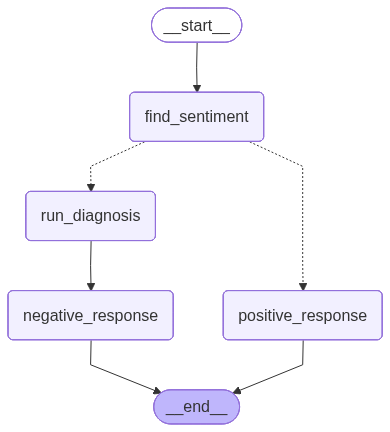

In [56]:
graph = StateGraph(ReviewState)

graph.add_node("find_sentiment", find_sentiment)
graph.add_node("positive_response", positive_response)
graph.add_node("run_diagnosis", run_diagnosis)
graph.add_node("negative_response", negative_response)

graph.add_edge(START, "find_sentiment")
graph.add_conditional_edges("find_sentiment", check_sentiment)

graph.add_edge("positive_response", END)

graph.add_edge("run_diagnosis", "negative_response")
graph.add_edge("negative_response", END)

# compile graph
workflow = graph.compile()

workflow

In [ ]:
initial_state = {"review": "I’ve been trying to log in for over an hour now, and the app keeps freezing on the authentication screen. I even tried reinstalling it, but no luck. This kind of bug is unacceptable, especially when it affects basic functionality."
}

final_state = workflow.invoke(initial_state)

final_state